**MA488 Project 3 \- O'Hara**


1. **Data Gathering and Preparation**



In [17]:
# Data from Kaggle: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data

!pip install kaggle
!kaggle datasets download -d snap/amazon-fine-food-reviews
! unzip amazon-fine-food-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
# import libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers
import tensorflow as tf
import numpy as np

In [19]:


# lists to store the data
texts = []
labels = []

csv_path = 'Reviews.csv'

# Read csv into df
df = pd.read_csv(csv_path)
#print(df.columns)

# Select the columns
df = df[['Text', 'ProductId']]


print(df.head())
df.to_csv('amazon-fine-food-reviews-processed.csv', index=False)

                                                Text   ProductId
0  I have bought several of the Vitality canned d...  B001E4KFG0
1  Product arrived labeled as Jumbo Salted Peanut...  B00813GRG4
2  This is a confection that has been around a fe...  B000LQOCH0
3  If you are looking for the secret ingredient i...  B000UA0QIQ
4  Great taffy at a great price.  There was a wid...  B006K2ZZ7K


2. **Data Preprocessing**



In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize


tfidf_vectorizer = TfidfVectorizer(max_df=0.15, min_df=2, stop_words="english") 
model = tfidf_vectorizer.fit_transform(df.Text)
model

from sklearn.decomposition import NMF

nmf = NMF(beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0).fit(model)

components_df = pd.DataFrame(nmf.components_, columns=tfidf_vectorizer.get_feature_names_out())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\john.clausing\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic].nlargest(15).index.to_list()
    wordlist = []
    for word in tmp:
        wordlist.insert(0, word)
    print(f'THE TOP 15 WORDS FOR TOPIC #{topic}')
    print(wordlist)
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['drink', 'mix', 'free', 'try', 'sweet', 'tastes', 'tried', 've', 'make', 'don', 'little', 'sugar', 'water', 'use', 'really']


THE TOP 15 WORDS FOR TOPIC #1
['morning', 'coffees', 'flavored', 'dark', 'starbucks', 'smooth', 'blend', 'bitter', 'keurig', 'roast', 'bold', 'cups', 'strong', 'cup', 'coffee']


THE TOP 15 WORDS FOR TOPIC #2
['grey', 'strong', 'earl', 'hot', 'drinking', 'chai', 'cup', 'stash', 'black', 'bags', 'iced', 'drink', 'teas', 'green', 'tea']


THE TOP 15 WORDS FOR TOPIC #3
['old', 'wet', 'quality', 'ingredients', 'diet', 'feed', 'chicken', 'wellness', 'foods', 'canned', 'dry', 'eat', 'cats', 'cat', 'food']


THE TOP 15 WORDS FOR TOPIC #4
['com', 'pack', 'bought', 'ordered', 'time', 'box', 'grocery', 'shipping', 'stores', 'local', 'order', 'buy', 'store', 'price', 'amazon']


THE TOP 15 WORDS FOR TOPIC #5
['bones', 'smell', 'toy', 'puppy', 'bag', 'chew', 'size', 'teeth', 'small', 'training', 'treat', 'loves', 'dogs', 'treats', 'dog']


TH

In [22]:
newCol = tfidf_vectorizer.transform(df.Text)
topics = nmf.transform(newCol)
topicMatches = pd.DataFrame(topics).idxmax(axis=1)
final = pd.concat([df, topicMatches], axis=1)
final.columns = ['Text', 'ProductId', 'Topic']
df = final

In [23]:
# (Allan), (cs95), (garg_ak0109), (Kohli), (Pandas.Dataframe.groupby), (Pandas.Dataframe.join)
grouped_df = df.groupby(['ProductId'])
grouped_df = grouped_df.agg(pd.Series.mode).reset_index()
grouped_df = grouped_df[['ProductId', 'Topic']]
grouped_df['new_column'] = [l[0] if isinstance(l, np.ndarray) else l for l in grouped_df['Topic']]
grouped_df

,ProductId,Topic,new_column
0,0006641040,0,0
1,141278509X,0,0
2,2734888454,5,5
3,2841233731,3,3
4,7310172001,5,5
...,...,...,...
74253,B009UOFTUI,1,1
74254,B009UOFU20,1,1
74255,B009UUS05I,0,0
74256,B009WSNWC4,4,4


In [24]:
df = df[['Text', 'ProductId']]
labeled_df = df.join(grouped_df.set_index('ProductId'), on='ProductId')
labeled_df = labeled_df[['Text', 'ProductId', 'new_column']]
labeled_df.columns = [['Text', 'ProductId', 'Topic']]
df = labeled_df

In [25]:
df.to_csv('amazon-fine-food-reviews-processed-one.csv', index=False)

In [26]:
df1 = pd.read_csv('amazon-fine-food-reviews-processed-one.csv')

In [27]:
# map classes to integers from 0...k-1
df1['targets'] = df1['Topic'].astype('category').cat.codes

df_train, df_test = train_test_split(df1, test_size = 0.3)

MAX_WORDS = 10000
MAX_LEN = 100

print(df_train)
tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token = '<OOV>')
tokenizer.fit_on_texts(df_train['Text'])

Xtrain = tokenizer.texts_to_sequences(df_train['Text'])
Xtest = tokenizer.texts_to_sequences(df_test['Text'])

Xtrain = pad_sequences(Xtrain, maxlen = MAX_LEN, padding = 'post', truncating = 'post')
Xtest = pad_sequences(Xtest, maxlen = MAX_LEN, padding = 'post', truncating = 'post')

Ytrain = df_train['targets']
Ytest = df_test['targets']

K = df1['targets'].max() + 1


                                                     Text   ProductId  Topic  \
248450  This is a fine product,great taste much less s...  B00016LZT8      0   
352186  You can't beat the price, but what I want from...  B0045GX66A      4   
322917  I've tried just about every extra bold K cup a...  B006N3I3Q6      1   
478562  This pepper packs a punch! I'm usually heavy h...  B002LLZX9E      0   
183300  I've ALWAYS been partial to chips ahoy because...  B004U43ZO0      7   
...                                                   ...         ...    ...   
191543  The pet food industry can be one of the most i...  B000WFN0VO      3   
529564  This blend isn't too harsh though.  Admittedly...  B0032CB15Q      1   
243393  Well, our friends at Click have done it again!...  B00305L330      0   
543705  This is much more convenient than buying and s...  B006MONQMC      0   
557638  They arrived quickly and packaged well.  Item ...  B003ZXHE5I      7   

        targets  
248450        0  
352

3. **Model Building and Training**



In [28]:
# build model
model = models.Sequential([
    layers.Embedding(input_dim = MAX_WORDS, output_dim = 128),
    layers.Conv1D(filters = 128, kernel_size = 5, activation = 'relu'),
    layers.GlobalMaxPool1D(),
    # 64 units (ouput dimension), relu activation
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(K, activation = 'sigmoid')
])

# adam -- adjusts the learning rate for each individual parameter -- better at making the model learn
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy,
    optimizer = 'adam',
    metrics = ['accuracy'])

In [29]:
#Train the Model
history = model.fit(
    Xtrain, Ytrain,
    validation_data = (Xtest, Ytest),
    epochs = 5,
    batch_size = 32
)

Epoch 1/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 161s 13ms/step - accuracy: 0.7247 - loss: 0.8127 - val_accuracy: 0.8106 - val_loss: 0.5231
Epoch 2/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 155s 12ms/step - accuracy: 0.8095 - loss: 0.5453 - val_accuracy: 0.8217 - val_loss: 0.4957
Epoch 3/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 155s 12ms/step - accuracy: 0.8318 - loss: 0.4739 - val_accuracy: 0.8293 - val_loss: 0.4959
Epoch 4/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 152s 12ms/step - accuracy: 0.8512 - loss: 0.4151 - val_accuracy: 0.8321 - val_loss: 0.5012
Epoch 5/5
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 156s 13ms/step - accuracy: 0.8716 - loss: 0.3595 - val_accuracy: 0.8324 - val_loss: 0.5363


4. **Model Evaluation and Optimization**



In [30]:
loss, accuracy = model.evaluate(Xtest, Ytest)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

5330/5330 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8318 - loss: 0.5368
Test Accuracy: 83.24%


5. **Reporting Results and Insights**



12435/12435 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
Train Accuracy : 0.9061060472410075
Test  Accuracy : 0.832429326187279

Classification Report : 
                    precision    recall  f1-score   support

             Drink       0.78      0.87      0.83     57885
            Coffee       0.93      0.95      0.94     21580
               Tea       0.95      0.92      0.93     15335
           Catfood       0.91      0.85      0.88     11390
Shipping(Nonsense)       0.67      0.53      0.59     26703
           Dogfood       0.93      0.92      0.92     14092
            Snacks       0.91      0.87      0.89      8154
            Sweets       0.84      0.84      0.84     15398

          accuracy                           0.83    170537
         macro avg       0.86      0.84      0.85    170537
      weighted avg       0.83      0.83      0.83    170537



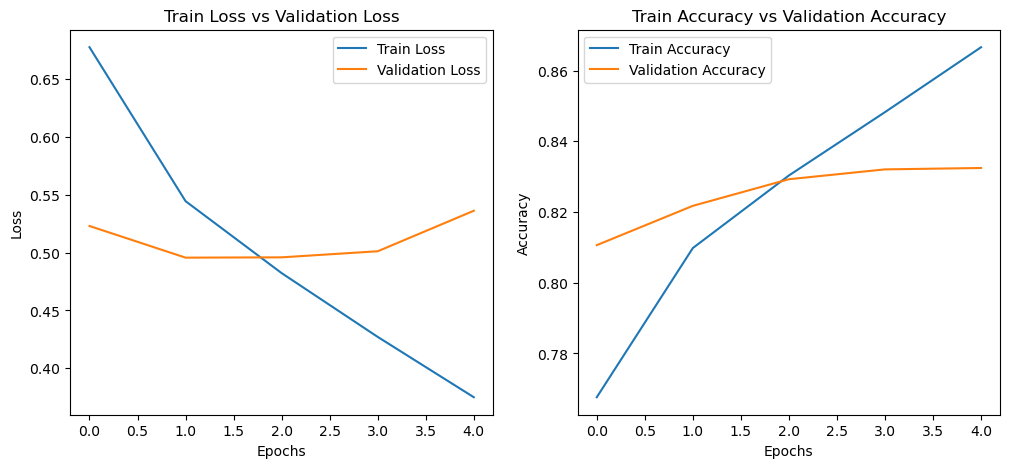

In [34]:
# add a graph here showing the loss per iteration
#(Solanki)
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");

plot_loss_and_acc(history)

# F1 score per category
from sklearn.metrics import accuracy_score, classification_report

train_preds = model.predict(Xtrain)
test_preds = model.predict(Xtest)
print("Train Accuracy : {}".format(accuracy_score(Ytrain, np.argmax(train_preds, axis=1))))
print("Test  Accuracy : {}".format(accuracy_score(Ytest, np.argmax(test_preds, axis=1))))
print("\nClassification Report : ")
print(classification_report(Ytest, np.argmax(test_preds, axis=1), target_names=['Drink','Coffee', 'Tea', 'Catfood', 'Shipping(Nonsense)','Dogfood', 'Snacks', 'Sweets']))

Write a quick paragraph highlighting:

- Model findings
- Performance metrics
- Suggested improvements



After establishing this model, it can be seen that it classifies the products based off the LDiA topics moderately well as it has an accuraccy of around 83%. From the graphs, it can also be seen that the model began to start to reach overfitting at epoch 4, so that is why it only ran 4 epochs. In terms of metrics, the Coffee category performed the bes with an F1 score of 0.95 and the Shipping(Nonsense) category performed the worst with an F1 score of 0.59. This is likely due to the Shipping(Nonsense) category being used as a miscellaneous set by the model. What is also interesting is that the metrics do not necessarily become better for the more entries per category. In order to improve this project, the dataset should have a labeled category section predefined because the LDiA classification is just an approximation and not 100% accurate to the actual product categories. Since that was the only way to get product categories though, we had to use it.

**Key Questions for the Project**

1. How effective is the CNN at performing multi\-label classification on Amazon reviews?
   1. The CNN was moderately effective at performing the multi label classification on the Amazon reviews. Since there was no product categorical variable as mentioned in the instructions, we defined our own using the LDia from the previous assignment. Overall the model performed moderately well with an accuracy of 83% and that average is being brought down significantly by the Shipping(Nonsense) category. While this is not great, it is better than random assignment.
2. What preprocessing steps improve CNN performance?
   1. Removing stopwords, tokenizing the data and padding improve CNN performance. By removing stopwords and tokenizing the data prior to analysis, the algorithm only has to analyze the relevant data for the CNN. Additionally, padding allows for equal analysis of all words since each word gets analyzed the same amount of times with padding. 
3. Do different CNN kernel sizes and pooling methods enhance pattern recognition in product categories?
   1. By varying the kernel size of a CNN, different amounts of words are able to be analyzed at a time. However, increasing the kernel size also will reduced the dimension of the data after pooling. While this is generally a good thing, too large of a kernel can lead to an ineffective model. When effectively used, these methods allow for dimension reduction that makes it easier for the CNN model to identify key features in the data without having to analyze the noise.(Geeks for Geeks)
4. Which categories are challenging to classify, and why?
   1. The Shipping(nonsense) category value scores are more challenging to classify since this is an abstract categorization that seems to just bin all the products that could not fit into one of the other main topics. Therefore, this category does not mean much in the overall sense of the data.
5. How does the CNN compare to baseline models like Logistic Regression for multi\-label classification?
   1. Unlike other models, CNNs take into account the order of data, so this allows for greater depth in classification. THe caveat though is that these models oftentimes take longer to run. Additionally, models like Logistic Regression, are only designed to do binary classifications, so multi class logistic regressions would involve multiple logistic regressions. (Sucky)

Works Cited
1. Allan, Dan. “Looking for Pandas “Ungroup By” Operation Opposite to .Groupby in the Following String Aggregation?” Stack Overflow, 21 Nov. 2013, stackoverflow.com/questions/20122521/looking-for-pandas-ungroup-by-operation-opposite-to-groupby-in-the-following.
   1. This source was used to identify how to ungroup a dataframe like in r.
2. cs95. “Getting the First Element from Each List in a Column of Lists.” Stack Overflow, 15 Jan. 2019, stackoverflow.com/questions/54203440/getting-the-first-element-from-each-list-in-a-column-of-lists.
   1. After using the mode command, products that were multimodal were stored as lists of modes. To use it in the model, only one entry could be used. This source showed how to select the first entry.
3. garg_ak0109. “Python | Check If a given Object Is a List or Not.” GeeksforGeeks, 19 Mar. 2019, www.geeksforgeeks.org/python-check-if-a-given-object-is-list-or-not/.
   1. This was used to identify whether the object was a list for when it took the first entry.
4. GeeksforGeeks. “CNN | Introduction to Pooling Layer.” GeeksforGeeks, 5 Aug. 2019, www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/. 
   1. This source was used to better understand how pooling layers work. What was learned from this was used to answer question 3.
5. Kohli, Sachin. “How to Use .Mode with Groupby.” Stack Overflow, 2024, stackoverflow.com/questions/74055486/how-to-use-mode-with-groupby.
   1. This source showed how to find the mode per product id.
6. “Pandas.DataFrame.groupby — Pandas 1.3.0 Documentation.” Pandas.pydata.org, pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html.
   1. This showed how to use the groupby command.
7. “Pandas.DataFrame.join — Pandas 2.2.1 Documentation.” Pandas.pydata.org, pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html.
   1. This showed how to join dataframes.
8. Solanki, Sunny. “Keras: CNNs with Conv1D for Text Classification Tasks.” Coderzcolumn.com, CoderzColumn, 2022, coderzcolumn.com/tutorials/artificial-intelligence/
keras-cnn-with-conv1d-for-text-classification. 
   1. This source was used to see how the geeral process for the code should work and specifically for the graphs and classification report sections.
9. Sucky, Rashida Nasrin. “Multiclass Classification Algorithm from Scratch with a Project in Python: Step by Step Guide.” Medium, 3 Nov. 2020, towardsdatascience.com/multiclass-classification-algorithm-from-scratch-with-a-project-in-python-step-by-step-guide-485a83c79992.
   1. This source was used to get an understanding of logistic regressions and multiclass logistic regressions. The information was then used to answer question 5.